### Import

In [1]:
import tensorflow as tf
# tf 2.0부터 keras는 tensorflow의 공식 API
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, optimizers

import numpy as np
np.set_printoptions(threshold=np.inf, linewidth=np.inf)
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
pd.set_option('display.max_row', 40000)
pd.set_option('display.max_column', 10000)

import os
import datetime
# Log Data가 저장될 디렉터리 경로 만들기
dir_name = "Learning_log"

def make_Tensorboard_dir(dir_name):
    root_logdir = os.path.join(os.curdir, dir_name)
    sub_dir_name = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    return os.path.join(root_logdir, sub_dir_name)

from os.path import join
import sqlite3
import glob
import csv

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2021-12-10 06:42:15.117763: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set


### Data

In [3]:
path = "one/*" #-------------------------자신의 db파일이 있는 폴더로 수정---------------------------
file_list =  glob.glob(path)
file_list_db = [file for file in file_list if file.endswith(".db")]
# print ("file_list: {}".format(file_list_db))
len(file_list_db)
# EventCode03이 일어났을 당시의 초당 주행기록 가져오기

time_slice = 3

temp1 = np.zeros((1,time_slice,10)) # srcrec_df2 초기화

srcrec_df2 =temp1 # 연결한 db들의 x data 저장소
srcrec_df4 = pd.DataFrame() # 연결한 db들의 y data 저장소

for i in range (0,len(file_list_db)):
    # event 파일 가져오기
    f = open('event.csv') #-------------------------자신의 event파일이 있는 폴더로 수정---------------------------
    csvReader = csv.reader(f)
    # db연결
    conn = sqlite3.connect(file_list_db[i])
    c = conn. cursor()
    # event 테이블 유무 확인 후, 있으면 제거
    c.execute('Drop Table If Exists event')
    # event 테이블 생성
    c.execute("create table event(CAR_RECDRV_KEY integer, EVENT_CODE text, EVENT_STDT text, EVENT_ENDT text)")
    # csv 파일 읽어 온 데이터 insert
    for row in csvReader:
        if row[7] == "EVENT_CODE":
            continue
        sql1 = "insert into event (CAR_RECDRV_KEY,EVENT_CODE, EVENT_STDT, EVENT_ENDT) values (?,?,?,?)"
        key= int(row[1])
        #key 추출
        if key != int(file_list_db[i][4:11]): #src에 자신의 db파일이 있어야함, 아니면 인덱스 수정할 것
            continue
        code = (row[7])
        #event 추출
        if code[-11:] != "EventCode03" and code[-11:] != "EventCode02" and code[-11:] != "EventCode10":
            continue
        stdt = (row[8])
        endt = (row[9])
        c.execute(sql1,(key,code,stdt,endt))
    #트랜잭션 저장
    conn.commit()
    #event03 뽐기 query 실행
    sql2 = 'SELECT SRCREC.srcValue, SRCREC.realTime, SRCREC.srcSpeed, SRCREC.srcRPM,\
    SRCREC.srcAPS, SRCREC.srcTPS, SRCREC.srcEngineLoad, SRCREC.srcIntakePress, SRCREC.srcIntakeAirTemp, ifnull(EVENT_CODE, "0") FROM SRCREC LEFT OUTER JOIN\
    (SELECT EVENT_CODE, EVENT_STDT s, EVENT_ENDT e FROM event\
    ) ON SRCREC.realTime BETWEEN strftime("%Y%m%d%H%M%S",s,"-6 seconds")\
     AND strftime("%Y%m%d%H%M%S",e)\
    EXCEPT \
    SELECT SRCREC.srcValue, SRCREC.realTime, SRCREC.srcSpeed, SRCREC.srcRPM,\
    SRCREC.srcAPS, SRCREC.srcTPS, SRCREC.srcEngineLoad, SRCREC.srcIntakePress, SRCREC.srcIntakeAirTemp, EVENT_CODE FROM SRCREC LEFT JOIN\
    (SELECT EVENT_CODE, EVENT_STDT s, EVENT_ENDT e FROM event\
    ) ON SRCREC.realTime BETWEEN strftime("%Y%m%d%H%M%S",s)\
     AND strftime("%Y%m%d%H%M%S",e)'
    query =  c.execute(sql2)
    cols = [column[0] for column in query.description]
    srcrec_df = pd.DataFrame.from_records(data=query.fetchall(), columns=cols)
    
    # 슬라이딩 윈도우 적용
    srcrec_df = srcrec_df.iloc[100:]
    srcrec_df3 = srcrec_df.loc[:,"ifnull(EVENT_CODE, \"0\")"]
    srcred_list =  srcrec_df.values
    seq_len = time_slice
    
    if len(srcred_list) -seq_len+1 <=0:
        continue
        
    data_matrix=[]
    for i in range(0, len(srcred_list)-seq_len+1): # data를 겹친다. 0 1 2 3 4 5 -> 1 2 3 4 5 6
        tmp_data = srcrec_df[i:i+seq_len]
        data_matrix.append(tmp_data)
    data_matrix_np = np.array(data_matrix)
   
    # 각 db의 슬라이딩 적용한 x data들 합치기
    srcrec_df2 = np.concatenate([srcrec_df2,data_matrix_np])
    
    # 슬라이딩 적용으로 인해 필요없는 y data 제거
    srcrec_df3 = srcrec_df3.iloc[time_slice - 1:]
    srcrec_df3 = pd.DataFrame(srcrec_df3)
    
    srcrec_df3.loc[srcrec_df3['ifnull(EVENT_CODE, "0")'].str.contains('EventCode'),'ifnull(EVENT_CODE, "0")']='EventCode'
    # 각 db의 슬라이딩 적용한 y data들 합치기
    srcrec_df4 = pd.concat([srcrec_df4, srcrec_df3], ignore_index=True)
    
    #db 연결 종
    c.close()
    conn.close()
    #파일 연결 종료
    f.close()
# srcrec_df2 : x data
# srcrec_df4 : y data
print(srcrec_df2.shape)
print(srcrec_df4.shape)

(5102, 3, 10)
(5101, 1)


1. srcrec_df2를 초기화할 때 넣어준 0을 지움
2. 여러 컬럼 중 x data에 사용할 컬럼들을 걸러냄

In [4]:
x_data = srcrec_df2[1:,:,2:9]
len(x_data)

5101

In [5]:
y_data = srcrec_df4.values[: ,0]

y_data = pd.get_dummies(y_data).values

y_data = y_data[:,0]

where_0 = np.where(y_data == 0)
where_1 = np.where(y_data == 1)

y_data[where_0] = 1
y_data[where_1] = 0
print(len(y_data))
#수정사항 categorical로 바꾸기
# y_data = to_categorical(y_data)

5101


### Change from sequence x data to image 

In [6]:
# imaging time series as unthresholded recurrence plot
def r_plot(data,delay=0):
    #input datatype data : ndarray, 1xn, n-number of samples in each series
    #input datatype delay : int, delay embedding for RP formation, default value is 1
    #output datatype rp : ndarray, nxn, unthresholded recurrence plot for series
    transformed = np.zeros([2,len(data)-delay])
    transformed[0,:] = data[0:len(data)-delay]
    transformed[1,:] = data[delay:len(data)]
    rp = np.zeros([len(data)-delay,len(data)-delay])
    for i in range(len(rp)):
        temp = np.tile(transformed[:,i],(len(rp),1)).T-transformed
        temp2 = np.square(temp)
        rp[i,:] = np.sum(temp2,axis=0)
    return np.array(rp).tolist()

In [7]:
import matplotlib.pyplot as plt

#RP embedding
total = []
for row in range(0, len(x_data)):
    RP=[]
    for col in range(0, len(x_data[row][0])):       
        toy_data=x_data[row,:,col]
        RP.append(r_plot(toy_data))
    total.append(RP)

total2 = []
for rp in total:
    RP2 = []
    myrp2 ={}
    for i in range(0, time_slice):
        myrp2[i] = np.zeros((time_slice, 7))
    for rp_count in range(0, len(myrp2)):
        myrp = myrp2[rp_count]
        rp_mini_count=0;
        for rp_mini in rp:
            for index in range(0, len(rp_mini[0])):
                myrp[index][rp_mini_count] = rp_mini[rp_count][index]
            rp_mini_count = rp_mini_count+1
            
    for key, value in myrp2.items():
        RP2.append(value)
        
    total2.append(RP2)     
    
print(len(total2[0]))
print(len(total2[0][0]))
print(len(total2[0][0][0]))
x_data = total2

3
3
7


### make the 0 and 1 ratio the same

In [8]:
import math

yindex=0
y1index=0
x1_data = []
y1_data = []

print(len(y_data))
for ydata in y_data:
    if ydata == 1:
        x1_data.append(x_data[yindex])
        y1_data.append(y_data[yindex])
        y1index= y1index+1
    yindex = yindex+1
print(y1index)

yindex=0
y1getindex=0 #가져오는 데이터 카운트 
for ydata in y_data:
    if ydata == 0:
        if y1getindex == math.floor(y1index*1.5):# event: normal = 1 : 1.5
            break
        x1_data.append(x_data[yindex])
        y1_data.append(y_data[yindex])
        y1getindex= y1getindex+1
    yindex = yindex+1


5101
48


In [9]:
x_data = np.array(x1_data)
y_data = np.array(y1_data)
#print(x_data[:10])
print(x_data.shape)

(120, 3, 3, 7)


### Hyper Parameters

In [10]:
learning_rate = 0.00005
batch_size = 256
training_epochs = 700

tf.random.set_seed(777) # weight 초기화용

### Creating a Checkpoint Directory

In [11]:
cur_dir = os.getcwd()
ckpt_dir_name = 'checkpoints'
model_dir_name = 'cnn_keras_sequential_eager_입력데이터 넣기 완료'

checkpoint_dir = os.path.join(cur_dir, ckpt_dir_name, model_dir_name)
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_prefix = os.path.join(checkpoint_dir, model_dir_name)

### split train and test 

In [12]:
from sklearn.model_selection import train_test_split
trnx, tstx, trny, tsty = train_test_split(x_data, y_data, test_size=0.2, random_state=111)
trnx, valx, trny, valy = train_test_split(trnx, trny, test_size=0.2, random_state=111)
# trnx = np.expand_dims(trnx,axis=-1)
# tstx = np.expand_dims(tstx,axis=-1)
print(len(trnx))
print(len(trny))

76
76


### Model Function

In [13]:
model = keras.Sequential()#이제 계층을 순차적으로 연결 가능
model.add(keras.layers.Conv2D(filters=128, kernel_size=3, activation=tf.nn.relu, padding='SAME', 
                              input_shape=(time_slice, time_slice, 7)))# input_shape => 첫 layer에만 선언
model.add(keras.layers.MaxPool2D(padding='SAME'))
model.add(keras.layers.Reshape((4,-1)))
model.add(keras.layers.LSTM(64, return_sequences=True))
model.add(keras.layers.LSTM(32, return_sequences=True))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation=tf.nn.relu))
#수정사항 2, softmax
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

2021-12-10 06:42:20.914970: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-10 06:42:20.919396: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 3, 3, 128)         8192      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 2, 2, 128)         0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 128)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 4, 64)             49408     
_________________________________________________________________
lstm_1 (LSTM)                (None, 4, 32)             12416     
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               3

In [15]:
from tensorflow.keras.callbacks import EarlyStopping


#수정사항 categorical
model.compile(loss='binary_crossentropy', optimizer = keras.optimizers.Adam(lr = learning_rate,) , metrics=['accuracy'])

# 텐서보드에 기록
TB_log_dir = make_Tensorboard_dir(dir_name)
TensorB = tf.keras.callbacks.TensorBoard(log_dir = TB_log_dir)

early_stopping = EarlyStopping(patience=20)

2021-12-10 06:42:21.477606: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-12-10 06:42:21.477651: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-12-10 06:42:21.477702: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


In [16]:
history = model.fit(x=trnx, y=trny, validation_data = (valx, valy), batch_size = batch_size, epochs = training_epochs,callbacks=[early_stopping, TensorB])

Epoch 1/700


2021-12-10 06:42:21.523954: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-12-10 06:42:21.544528: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199955000 Hz


1/1 [==============================] - 8s 8s/step - loss: 0.6896 - accuracy: 0.5658 - val_loss: 0.6848 - val_accuracy: 0.5000
Epoch 2/700
1/1 [==============================] - ETA: 0s - loss: 0.6869 - accuracy: 0.5789

2021-12-10 06:42:29.926806: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-12-10 06:42:29.926881: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.


1/1 [==============================] - 0s 443ms/step - loss: 0.6869 - accuracy: 0.5789 - val_loss: 0.6839 - val_accuracy: 0.4500


2021-12-10 06:42:30.085636: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2021-12-10 06:42:30.130945: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-12-10 06:42:30.189413: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./Learning_log/20211210-064221/train/plugins/profile/2021_12_10_06_42_30
2021-12-10 06:42:30.214477: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to ./Learning_log/20211210-064221/train/plugins/profile/2021_12_10_06_42_30/ckserver.trace.json.gz
2021-12-10 06:42:30.255895: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./Learning_log/20211210-064221/train/plugins/profile/2021_12_10_06_42_30
2021-12-10 06:42:30.260035: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for memory_profile.json.gz to ./Learning_log/20211210-064221/train/plu

Epoch 3/700
1/1 [==============================] - 0s 492ms/step - loss: 0.6841 - accuracy: 0.6447 - val_loss: 0.6844 - val_accuracy: 0.5000
Epoch 4/700
1/1 [==============================] - 0s 452ms/step - loss: 0.6831 - accuracy: 0.6184 - val_loss: 0.6827 - val_accuracy: 0.6000
Epoch 5/700
1/1 [==============================] - 0s 368ms/step - loss: 0.6811 - accuracy: 0.6316 - val_loss: 0.6865 - val_accuracy: 0.6000
Epoch 6/700
1/1 [==============================] - 1s 740ms/step - loss: 0.6805 - accuracy: 0.6316 - val_loss: 0.6853 - val_accuracy: 0.6000
Epoch 7/700
1/1 [==============================] - 0s 374ms/step - loss: 0.6791 - accuracy: 0.6316 - val_loss: 0.6805 - val_accuracy: 0.6000
Epoch 8/700
1/1 [==============================] - 0s 328ms/step - loss: 0.6774 - accuracy: 0.6316 - val_loss: 0.6810 - val_accuracy: 0.6000
Epoch 9/700
1/1 [==============================] - 1s 628ms/step - loss: 0.6762 - accuracy: 0.6316 - val_loss: 0.6805 - val_accuracy: 0.6000
Epoch 10/700


Epoch 61/700
1/1 [==============================] - 1s 585ms/step - loss: 0.6390 - accuracy: 0.6447 - val_loss: 0.6668 - val_accuracy: 0.6000
Epoch 62/700
1/1 [==============================] - 1s 705ms/step - loss: 0.6384 - accuracy: 0.6447 - val_loss: 0.6678 - val_accuracy: 0.6000
Epoch 63/700
1/1 [==============================] - 1s 659ms/step - loss: 0.6379 - accuracy: 0.6447 - val_loss: 0.6669 - val_accuracy: 0.6000
Epoch 64/700
1/1 [==============================] - 1s 778ms/step - loss: 0.6374 - accuracy: 0.6447 - val_loss: 0.6666 - val_accuracy: 0.6000
Epoch 65/700
1/1 [==============================] - 1s 569ms/step - loss: 0.6372 - accuracy: 0.6447 - val_loss: 0.6651 - val_accuracy: 0.6000
Epoch 66/700
1/1 [==============================] - 1s 883ms/step - loss: 0.6372 - accuracy: 0.6447 - val_loss: 0.6663 - val_accuracy: 0.6000
Epoch 67/700
1/1 [==============================] - 1s 621ms/step - loss: 0.6363 - accuracy: 0.6447 - val_loss: 0.6662 - val_accuracy: 0.6000
Epoch 

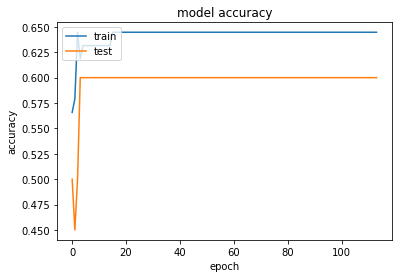

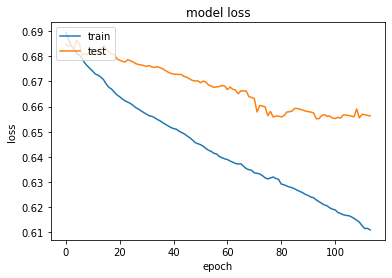

0.6000000238418579
0.6000000238418579


In [17]:
# summerize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summerize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# test data 마지막 정확도
print(history.history['val_accuracy'][-1])
# test data 가장 높은 정확도
print(np.max(history.history['val_accuracy']))

In [18]:
#sigmoid
y_pred = model.predict(tstx, batch_size=batch_size)
a = 0
b = 0
c = 0
d = 0
for i in range(len(y_pred)) :
    if y_pred[i] < 0.5 : # event03 발생 X 추측
        if tsty[i] == 0 :
            a = a + 1
        else :
            b=b + 1
    else : # event03 발생 O 추측
        if tsty[i] == 1 : 
            c=c + 1
        else :
            d= d+ 1
print("실제 : 0, 예측 : 0 - ", a)
print("실제 : 1, 예측 : 0 - ", b)
print("실제 : 1, 예측 : 1 - ", c)
print("실제 : 0, 예측 : 1 - ", d)
print("총 개수 : ", len(y_pred))
print("accuracy : ", (a+c)/(len(y_pred)))

#categorical
# a = 0
# b = 0
# c = 0
# d = 0
# for i in range(len(y_pred[:,0])) :
#     if y_pred[i,0] > y_pred[i,1] : # event03 발생 X
#         if tsty[i,1] == 0 :
#             a = a + 1
#         else :
#             b = b + 1
#     else :
#         if tsty[i,1] == 1 : # event03 발생 
#             c = c + 1
#         else :
#             d = d+ 1
# print("실제 : 0, 예측 : 0 -> ", a)
# print("실제 : 1, 예측 : 0 -> ", b)
# print("실제 : 1, 예측 : 1 -> ", c)
# print("실제 : 0, 예측 : 1 -> ", d)
# print("전체데이터 개수 : ", len(y_pred[:,0]))

실제 : 0, 예측 : 0 -  13
실제 : 1, 예측 : 0 -  11
실제 : 1, 예측 : 1 -  0
실제 : 0, 예측 : 1 -  0
총 개수 :  24
accuracy :  0.5416666666666666
